"In The Name Of ALLAH"
# Music generation using C-RNN-GAN with MIDI network input
Seyed Mohammadsaleh Mirzatabatabaei (smsmt@aut.ac.ir)

Salman Amimotlagh (motlaq@aut.ac.ir)

Aria Espahbodi (aria.esp@aut.ac.ir)

---





![RNN vs DNN t](https://salu133445.github.io/musegan/figs/multitrack1.png)

### Download & Import packages

---

In [1]:
!apt install fluidsynth
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2
!pip install midi2audio
!pip install music21

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin libinput10
  libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5 libqt5gui5 libqt5network5
  libqt5svg5 libqt5widgets5 libwacom-bin libwacom-common libwacom9 libxcb-icccm4 libxcb-image0
  libxcb-keysyms1 libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1
  libxkbcommon-x11-0 qsynth qt5-gtk-platformtheme qttranslations5-l10n timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs qt5-image-formats-plugins qtwayland5 jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin libinput10
  libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5 libqt5gui5 libqt5network5
  libqt5svg5 libqt5widgets5 libwacom-bin libwacom-common libwacom9 libxcb-icc

In [2]:
import sys, os, glob
import pickle
import matplotlib.pyplot as plt
import numpy as np

from music21 import *
from midi2audio import FluidSynth
from IPython.display import Audio

from keras.layers import Input, Dense, Reshape, Dropout, LSTM, Bidirectional
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers.legacy import Adam
from keras import utils

import tensorflow as tf

### MIDI class

---

In [3]:
class MIDI():
    def __init__(self, seq_length):
        self.seq_length = seq_length
        self.file_notes = []
        self.trainseq = []
        self.transfer_dic = dict()
        self.dic_n = 0

    def parser(self, folderName):
        """ Get all the rests and notes and chords from the midi files """

        for file in glob.glob(f"{folderName}/*.mid"):
            midi = converter.parse(file)
            print("Parsing %s" % file)

            notes = []
            for element in midi.flat.elements:
                if isinstance(element, note.Rest) and element.offset != 0:
                    notes.append('R')
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                if isinstance(element, chord.Chord):
                    notes.append('.'.join(str(pitch) for pitch in element.pitches))

            self.file_notes.append(notes)
        note_set = sorted(set(note for notes in self.file_notes for note in notes))
        self.dic_n = len(note_set)
        # A dictionary to map notes, chords and rest to integers
        self.transfer_dic = dict((note, number) for number, note in enumerate(note_set))

    def prepare_sequences(self):
        """ Prepare the sequences used by the Neural Network """

        # create input sequences and the corresponding outputs
        for notes in self.file_notes:
            for i in range(len(notes) - self.seq_length):
                self.trainseq.append([self.transfer_dic[note] for note in notes[i:i + self.seq_length]])

        # Normalize sequences between -1 and 1
        self.trainseq = np.array(self.trainseq)
        self.trainseq = (self.trainseq - float(self.dic_n) / 2) / (float(self.dic_n) / 2)

        return self.trainseq

    def create_midi(self, prediction_output, filename):
        """ convert the output from the prediction to notes and create a midi file
        from the notes """
        offset = 0
        midi_stream = stream.Stream()

        # create note and chord objects based on the values generated by the model
        for pattern in prediction_output:
            # rest
            if pattern == 'R':
                midi_stream.append(note.Rest())
            # chord
            elif ('.' in pattern) or pattern.isdigit():
                notes_in_chord = pattern.split('.')
                notes = []
                for current_note in notes_in_chord:
                    new_note = note.Note(current_note)
                    new_note.storedInstrument = instrument.Piano()
                    notes.append(new_note)
                new_chord = chord.Chord(notes)
                new_chord.offset = offset
                midi_stream.append(new_chord)
            # note
            else:
                new_note = note.Note(pattern)
                new_note.offset = offset
                new_note.storedInstrument = instrument.Piano()
                midi_stream.append(new_note)

            # increase offset each iteration so that notes do not stack
            offset += 0.5

        # midi_stream.show('text')
        midi_stream.write('midi', fp=f'{filename}.mid')

### Models summary

---



> **Discriminator**



In [4]:
discriminator = Sequential()
discriminator.add(LSTM(512, input_shape=(100, 1), return_sequences=True))
discriminator.add(Bidirectional(LSTM(512)))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 512)          1052672   
                                                                 
 bidirectional (Bidirection  (None, 1024)              4198400   
 al)                                                             
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                        



> **Generator**



In [5]:
generator = Sequential()
generator.add(LSTM(512, input_shape=(1000, 1), return_sequences=True))
generator.add(Bidirectional(LSTM(512)))
generator.add(Dense(512))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(512))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(1024))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(np.prod((100, 1)), activation='tanh'))
generator.add(Reshape((100, 1)))
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1000, 512)         1052672   
                                                                 
 bidirectional_1 (Bidirecti  (None, 1024)              4198400   
 onal)                                                           
                                                                 
 dense_3 (Dense)             (None, 512)               524800    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 512)               0         
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dense_4 (Dense)             (None, 512)              

### Model class

---

In [6]:
class MODEL():
  def __init__(self, midi_obj):
    self.midi = midi_obj
    self.seq_length = self.midi.seq_length
    self.seq_shape = (self.seq_length, 1)
    self.latent_dim = 1000
    self.disc_loss = []
    self.gen_loss = []

    optimizer = Adam(0.0002, 0.5)

    # Build and compile the discriminator
    self.discriminator = self.build_discriminator()
    self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Build the generator
    self.generator = self.build_generator()

    # The generator takes noise as input and generates note sequences
    z = Input(shape=(self.latent_dim, 1))
    generated_seq = self.generator(z)

    # For the combined model we will only train the generator
    self.discriminator.trainable = False

    # The discriminator takes generated images as input and determines validity
    validity = self.discriminator(generated_seq)

    # The combined model  (stacked generator and discriminator)
    # Trains the generator to fool the discriminator
    self.combined = Model(z, validity)
    self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

  def build_discriminator(self):
    model = Sequential()
    model.add(LSTM(512, input_shape=self.seq_shape, return_sequences=True))
    model.add(Bidirectional(LSTM(512)))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    # model.summary()

    seq = Input(shape=self.seq_shape)
    validity = model(seq)

    return Model(seq, validity)

  def build_generator(self):
    model = Sequential()
    model.add(LSTM(512, input_shape=(self.latent_dim, 1), return_sequences=True))
    model.add(Bidirectional(LSTM(512)))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(self.seq_shape), activation='tanh'))
    model.add(Reshape(self.seq_shape))
    # model.summary()

    noise = Input(shape=(self.latent_dim, 1))
    seq = model(noise)

    return Model(noise, seq)

  def train(self, epochs, dataFolder, batch_size=128, sample_interval=50):
    # Load and the data
    notes = self.midi.parser(dataFolder)
    sequences = self.midi.prepare_sequences()

    print(f"\nNumber of sequences for train: {sequences.shape[0]}\n")

    # Adversarial ground truths
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    # Training the model
    for epoch in range(epochs):
      # Training the discriminator
      # Select a random batch of note sequences
      index_seqs = np.random.randint(0, sequences.shape[0], batch_size)
      real_seqs = sequences[index_seqs]

      # Random noise for generator input
      noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

      # Generate a batch of new note sequences
      gen_seqs = self.generator.predict(noise)
      gen_seqs = tf.squeeze(gen_seqs, axis=-1)
      print(f"{real_seqs.shape}-{gen_seqs.shape}")

      # Train the discriminator
      #try:
      d_loss_real = self.discriminator.train_on_batch(real_seqs, real)
      d_loss_fake = self.discriminator.train_on_batch(gen_seqs, fake)
      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

      #  Training the Generator
      noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

      # Train the generator (to have the discriminator label samples as real)
      g_loss = self.combined.train_on_batch(noise, real)

      # Print the progress and save into loss lists
      if epoch % sample_interval == 0:
          print("%d / %d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (
          epoch + 1, epochs, d_loss[0], 100 * d_loss[1], g_loss))
          self.disc_loss.append(d_loss[0])
          self.gen_loss.append(g_loss)
      # except Exception as e:
      #   print("FAIL")

    print(f"The C-RNN-GAN model have been trained with {dataFolder} midi music,\n" +
          "and you can save your model using save method.")


  def save(self):
    # create Model directory if there isn't exist
    if not os.path.exists('Model/'):
      os.makedirs('Model/')

    # save discriminator and generator trained model
    self.discriminator.save('Model/discriminator.h5')
    self.generator.save('Model/generator.h5')
    print("The trained C-RNN-GAN model (generator and discriminator) have been saved in the Model folder.")


  def generate(self):
    """ Use random noise to generate music"""

    # random noise for network input
    noise = np.random.normal(0, 1, (1, self.latent_dim))
    predictions = self.generator.predict(noise)

    # transfer sequence numbers to notes
    boundary = int(len(self.midi.transfer_dic) / 2)
    pred_nums = [x * boundary + boundary for x in predictions[0]]
    notes = [key for key in self.midi.transfer_dic]
    pred_notes = [notes[int(x) % len(notes)] for x in pred_nums] # % len(notes)

    # create Result directory if there isn't exist
    if not os.path.exists('Result/'):
      os.makedirs('Result/')

    # generate music with .midi format
    self.midi.create_midi(pred_notes, 'Result/gan_final')


  def plot_loss(self):
    """ Plot and save discriminator and generator loss functions per epoch diagram"""
    plt.plot(self.disc_loss, c='red')
    plt.plot(self.gen_loss, c='blue')
    plt.title("GAN Loss per Epoch")
    plt.legend(['Discriminator', 'Generator'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    plt.savefig('Result/GAN_Loss_per_Epoch_final.png', transparent=True)
    plt.close()

In [ ]:
midi = MIDI(seq_length=16)
model = MODEL(midi_obj=midi)
model.train(50, dataFolder='data2', batch_size=128, sample_interval=1)

Parsing data2/5 Bmin 70.mid
Parsing data2/UNISON_MELODYLOOP_Beep - Piano (174 BPM - F#m).mid
Parsing data2/UNISON_MELODYLOOP_Player One - Synth Pluck (166  BPM - Ebm).mid
Parsing data2/UNISON_MELODYLOOP_Daytons - Synth Stab (104 BPM - Bbm).mid
Parsing data2/UNISON_MELODYLOOP_Icebox - Piano (184 BPM - Dm).mid
Parsing data2/UNISON_MELODYLOOP_Ice Cold - Strings (128 BPM - Cm).mid
Parsing data2/UNISON_MELODYLOOP_Rollin - Pluck 2 (160 BPM - Cm).mid
Parsing data2/UNISON_MELODYLOOP_Player One - Theremin (166 BPM - Ebm).mid
Parsing data2/UNISON_MELODYLOOP_Queen St - Bass (140 BPM - Gm).mid
Parsing data2/UNISON_MELODYLOOP_Beep - Guitar (174 BPM - F#m).mid
Parsing data2/UNISON_MELODYLOOP_Daytons - Bass (104 BPM - Bbm).mid
Parsing data2/UNISON_MELODYLOOP_Pyramids - Bass (106 BPM - Em).mid
Parsing data2/UNISON_MELODYLOOP_Don't Be Mad - Pluck (101 BPM - Cm).mid
Parsing data2/UNISON_MELODYLOOP_Icebox - Guitar (184 BPM - Dm).mid
Parsing data2/UNISON_MELODYLOOP_Daytons - Rhodes (104 BPM - Bbm).mid
Par

### Save Model

---

In [39]:
model.save()

The trained C-RNN-GAN model (generator and discriminator) have been saved in the Model folder.


### Generate Music

---

In [19]:
# ONLY IF YOU NEED TO RELOAD THE MODEL

# import keras
# midi = MIDI(seq_length=8)
# model = MODEL(midi_obj=midi)
# model.midi.parser("data2")
# model.midi.prepare_sequences()
# model.generator = keras.models.load_model('Model/generator.h5')

Parsing data2/Cymatics - Eternity MIDI 19 - A Min.mid
Parsing data2/Cymatics - Eternity MIDI 2 - C Min.mid
Parsing data2/Cymatics - Lofi MIDI 3 - C Min.mid
Parsing data2/Piano MIDI 2.mid
Parsing data2/Rhodes MIDI (3).mid
Parsing data2/Rhodes MIDI (8).mid
Parsing data2/Cymatics - Eternity MIDI 15 - A Maj.mid
Parsing data2/Cymatics - Eternity MIDI 12 - A Min.mid
Parsing data2/Piano MIDI (5).mid
Parsing data2/Cymatics - Eternity MIDI 3 - D Maj.mid
Parsing data2/Cymatics - Eternity MIDI 17 - A Maj.mid
Parsing data2/Piano MIDI (4).mid
Parsing data2/Cymatics - Lofi MIDI 11 - E Maj.mid
Parsing data2/Piano MIDI.mid
Parsing data2/Cymatics - Eternity MIDI 9 - F Min.mid
Parsing data2/Rhodes MIDI (9).mid
Parsing data2/Rhodes MIDI.mid
Parsing data2/Cymatics - Eternity MIDI 7 - E Min.mid
Parsing data2/8.mid
Parsing data2/Piano MIDI (8).mid
Parsing data2/Rhodes MIDI (6).mid
Parsing data2/Piano MIDI (7).mid
Parsing data2/1.mid
Parsing data2/Cymatics - Lofi MIDI 22 - B Min.mid
Parsing data2/E-Piano MID

In [51]:
model.generate()


1/1 [==============================] - 2s 2s/step


In [52]:
!fluidsynth -ni font.sf2 Result/gan_final.mid -F Result/output.wav -r 44100

sound_file = './Result/output.wav'
Audio(sound_file)

FluidSynth runtime version 2.2.5
Copyright (C) 2000-2022 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'Result/output.wav'..


### Model loss function

---

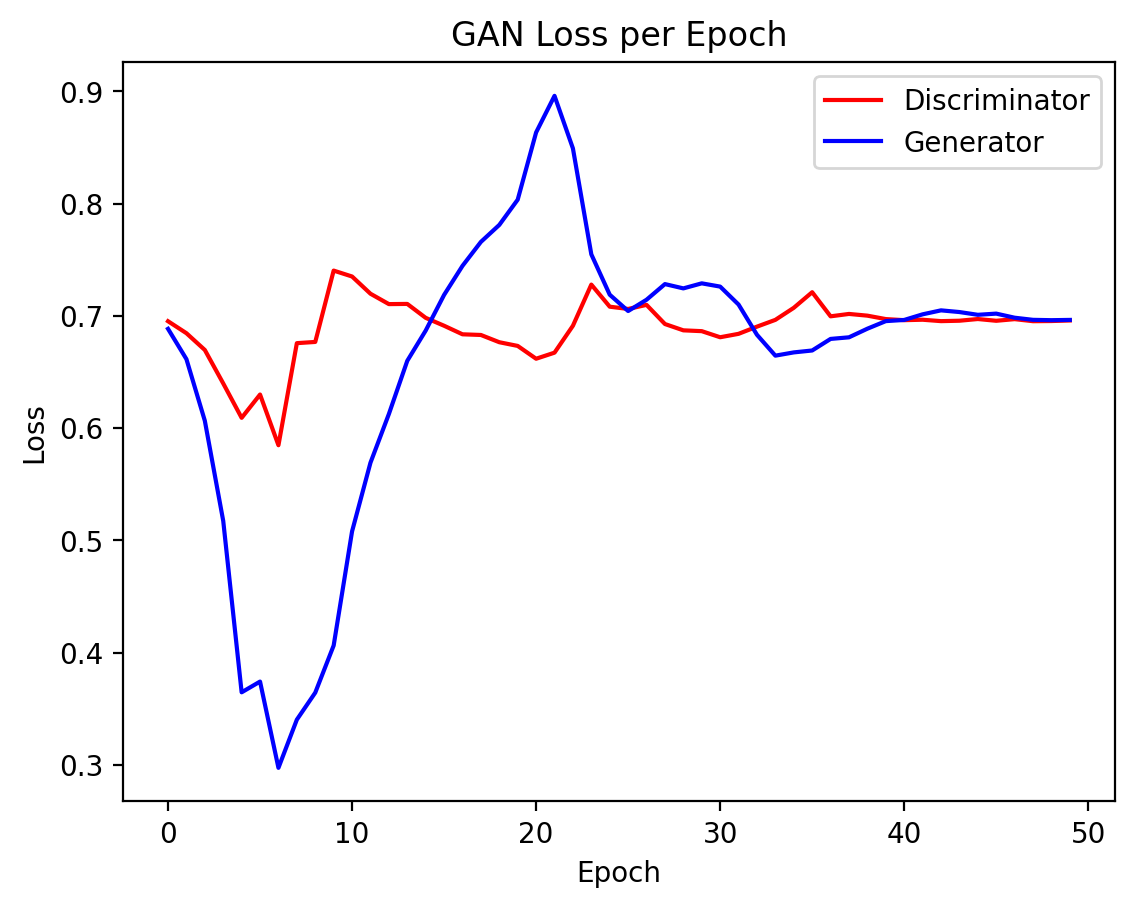

In [48]:
model.plot_loss()